In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [47]:
df = pd.read_csv('AMZN_Intra_Export.csv')
df.head()

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-03-13 09:45:00,1769.9086,1789.3783,1727.7496,1734.0012,984208.0
1,2020-03-13 10:00:00,1735.8700,1738.6500,1716.9700,1728.4300,317717.0
2,2020-03-13 10:15:00,1728.7200,1745.6100,1724.0000,1737.0601,271991.0
3,2020-03-13 10:30:00,1737.3400,1767.3800,1734.0100,1745.5933,376255.0
4,2020-03-13 10:45:00,1747.8900,1749.5200,1727.5100,1729.4000,218246.0


In [0]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [49]:
states_buy, states_sell, total_gains, invest = buy_stock(df['4. close'], initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 1734.001200, total balance 8265.998800
day 12, sell 1 units at price 1717.160000, investment -0.971233 %, total balance 9983.158800,
day 21: buy 1 units at price 1716.930000, total balance 8266.228800
day 27, sell 1 units at price 1689.060000, investment -1.623246 %, total balance 9955.288800,
day 39: buy 1 units at price 1709.900000, total balance 8245.388800
day 47, sell 1 units at price 1726.870000, investment 0.992456 %, total balance 9972.258800,
day 56: buy 1 units at price 1775.979400, total balance 8196.279400
day 67, sell 1 units at price 1793.613400, investment 0.992917 %, total balance 9989.892800,
day 75: buy 1 units at price 1792.010000, total balance 8197.882800
day 85, sell 1 units at price 1806.255000, investment 0.794917 %, total balance 10004.137800,
day 92: buy 1 units at price 1772.689900, total balance 8231.447900
day 99, sell 1 units at price 1820.297900, investment 2.685636 %, total balance 10051.745800,
day 112: buy 1 units at price 1

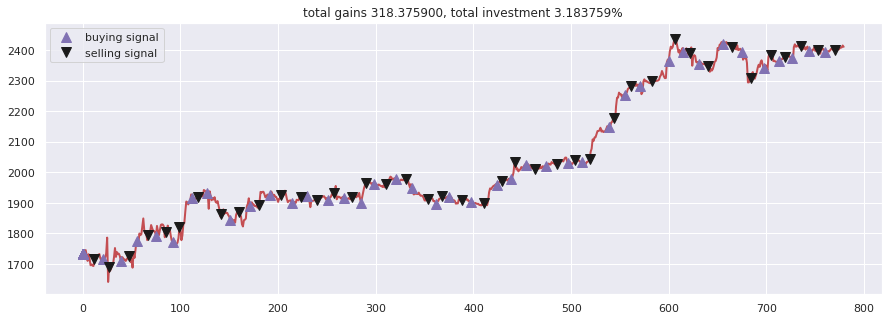

In [50]:
close = df['4. close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()